# JSTOR EDA and Journal Selector

### Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import os
import altair as alt
alt.renderers.enable("mimetype")
alt.data_transformers.enable('default', max_rows=None)
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import ast

import community as community_louvain
import leidenalg
import igraph as ig
import networkx as nx
from pyvis.network import Network
from networkx.algorithms import bipartite


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from kneed import KneeLocator
import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append("../")
from scripts.utils import *

In [5]:
set_data_directory_path("../data/public_data/")
data_directory_path = get_data_directory_path()
finalized_discipline_data = pd.read_csv(f"{data_directory_path}processed_jstor_files/finalized_disciplines_metadata.csv")
finalized_publication_data = pd.read_csv(f"{data_directory_path}processed_jstor_files/finalized_publication_metadata.csv")

JSTOR journal selector data directory path set to ../data/public_data/

### Cluster and Predict Likely Journals by Discipline

#### Shared Functions

In [6]:
def clean_lists(row, discipline_column):
    list_of_disciplines = row[discipline_column]
    if isinstance(list_of_disciplines, str):
        list_of_disciplines = ast.literal_eval(list_of_disciplines)
        list_of_disciplines = [x.strip() for x in list_of_disciplines]
        row[discipline_column] = list_of_disciplines
    return row

In [7]:
def create_correlation_matrix_and_pivot_table(df, column_index, column_columns):
    if column_index not in df.columns or column_columns not in df.columns:
        raise ValueError(f"Columns {column_index} or {column_columns} not found in DataFrame")

    matrix_df = df[[column_index, column_columns]]
    pivot_df = pd.pivot_table(matrix_df, index=column_index, columns=column_columns, aggfunc=len, fill_value=0)
    
    correlation_matrix = pivot_df.corr()
    correlation_matrix.reset_index(inplace=True)
    correlation_matrix.index.name = None
    return correlation_matrix, pivot_df

In [8]:
def generate_matrix_heatmap(correlation_matrix, column_index, title=None):
    # Melt the correlation matrix into a long-form DataFrame
    long_form = correlation_matrix.melt(id_vars=[f'{column_index}'], var_name='column', value_name='correlation')
    finalized_title = f'{title.capitalize()} Correlation Heatmap' if title else f'{column_index.capitalize()} Correlation Heatmap'
    # Create the heatmap with Altair
    heatmap = alt.Chart(long_form).mark_rect().encode(
        x=alt.X(f'{column_index}:O', axis=alt.Axis(labelAngle=-45)),  # This will sort the x-axis based on the y-axis values in descending order
        y=alt.Y('column:O', sort=alt.EncodingSortField('column', order='descending')),
        color='correlation:Q',
        tooltip=[f'{column_index}', 'column', 'correlation']
    ).properties(
        title=finalized_title,
    ).configure_axis(
        labelFontSize=10,  # Adjust font size if needed
        labelPadding=10,  # Adjust label padding if needed
    )

    return heatmap, long_form

In [9]:
def evaluate_clusters(pivot_df, max_k=10):
    silhouette_scores = []
    elbow_df = pd.DataFrame(columns=['k', 'inertia'])
    
    for k in range(2, max_k + 1):
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(pivot_df)

        # Calculate silhouette scores
        silhouette_avg = silhouette_score(pivot_df, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        # Compute the inertia for the elbow method
        elbow_df = elbow_df.append({'k': k, 'inertia': kmeans.inertia_}, ignore_index=True)

    elbow_df['k'] = elbow_df['k'].astype(int)
    elbow_df['inertia'] = elbow_df['inertia'].astype(int)
    # Detecting the elbow point
    kn = KneeLocator(elbow_df['k'], elbow_df['inertia'], curve='convex', direction='decreasing')
    optimal_k = kn.knee if kn.knee else max_k

    return silhouette_scores, elbow_df, optimal_k


def plot_silhouette_scores(silhouette_scores, max_k):
    """
    Plot silhouette scores for different numbers of clusters.
    
    :param silhouette_scores: List of silhouette scores for each number of clusters.
    :param max_k: Maximum number of clusters.
    """
    plt.figure(figsize=(8, 5))  # Adjust the figure size for better visibility
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.grid(True)  # Add a grid for easier reading
    plt.xticks(range(2, max_k + 1))  # Ensure x-axis ticks for each cluster number
    plt.show()


def plot_elbow_curve(elbow_df):
    """
    Plot the elbow curve for the given elbow DataFrame.
    
    :param elbow_df: DataFrame containing 'k' and 'inertia' for different numbers of clusters.
    """
    plt.figure()
    plt.plot(elbow_df['k'], elbow_df['inertia'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()



In [10]:
def create_clusters(pivot_df, comparison_title, type_clustering, max_k=10):
    """
    Create and visualize clusters using KMeans, and determine the optimal number of clusters.

    :param pivot_df: DataFrame to be used for clustering.
    :param comparison_title: Title for comparison.
    :param type_clustering: Type of clustering to perform ('UMAP' or 'PCA').
    :param max_k: Maximum number of clusters to try.
    :return: DataFrame with cluster assignments.
    """
    # Evaluate the clusters and determine the optimal number of clusters
    silhouette_scores, elbow_df, optimal_k = evaluate_clusters(pivot_df, max_k)

    # Plot silhouette scores and elbow curve
    plot_silhouette_scores(silhouette_scores, max_k)
    plot_elbow_curve(elbow_df)

    print("Optimal number of clusters determined to be:", optimal_k)

    # Perform K-means clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(pivot_df)
    # Use UMAP to reduce dimensionality for visualization
    if type_clustering == "UMAP":
        pivot_df['umap_cluster'] = clusters
        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(pivot_df.drop('umap_cluster', axis=1))

        # Create a DataFrame for the embedding
        embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
        embedding_df['cluster'] = clusters

        # Visualize the clusters
        sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', hue='cluster', palette='viridis')


    elif type_clustering == "PCA":
        pivot_df['pca_cluster'] = clusters
        # Reduce the dimensionality for visualization
        # Determine the number of components for 95% variance
        pca = PCA()
        pca.fit(pivot_df.drop('pca_cluster', axis=1))
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        d = np.argmax(cumsum >= 0.95) + 1
        if d > 3:
            d = 3
        pca = PCA(n_components=d)
        reduced_data = pca.fit_transform(pivot_df.drop('pca_cluster', axis=1))

        # Create a DataFrame for the reduced data
        reduced_df = pd.DataFrame(reduced_data, columns=['PCA' + str(i) for i in range(1, d+1)])
        reduced_df['cluster'] = clusters

        # Visualize the clusters
        if d == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            ax.scatter(reduced_df['PCA1'], reduced_df['PCA2'], reduced_df['PCA3'], c=reduced_df['cluster'])

            ax.set_xlabel('PCA1')
            ax.set_ylabel('PCA2')
            ax.set_zlabel('PCA3')
        else:
            sns.scatterplot(data=reduced_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
    plt.title(f'Clusters of {comparison_title} with {type_clustering}')
    plt.show()

    return pivot_df

In [11]:
def update_edge_weights(G, old_attr, new_attr):
    """
    Update the edge attribute names in a NetworkX graph.

    :param G: NetworkX graph.
    :param old_attr: The current name of the edge attribute.
    :param new_attr: The new name for the edge attribute.
    """
    for u, v, data in G.edges(data=True):
        if old_attr in data:
            data[new_attr] = data.pop(old_attr)
        else:
            raise ValueError(f"Edge attribute '{old_attr}' not found")

def remove_or_transform_negative_weights(G, method='remove'):
    """
    Remove or transform negative weights in the graph.

    :param G: NetworkX graph.
    :param method: 'remove' to remove negative weights or 'transform' to make them positive.
    """
    if method not in ['remove', 'transform']:
        raise ValueError("Method must be 'remove' or 'transform'")

    for u, v, data in G.edges(data=True):
        if data['weight'] < 0:
            if method == 'remove':
                data['weight'] = 0  # Set negative weights to zero
            elif method == 'transform':
                # Example transformation: add the absolute value of the minimum weight to all weights
                min_weight = min(nx.get_edge_attributes(G, 'weight').values())
                data['weight'] += abs(min_weight)

def convert_nx_to_igraph(nx_graph):
    g_ig = ig.Graph()
    g_ig.add_vertices(list(nx_graph.nodes()))
    g_ig.add_edges(list(nx_graph.edges()))
    g_ig.es['weight'] = list(nx.get_edge_attributes(nx_graph, 'weight').values())

    # Assign node names in iGraph
    g_ig.vs['name'] = list(nx_graph.nodes())

    return g_ig


def calculate_network_metrics(G):
    """Calculate various network metrics."""
    metrics = {
        'pagerank': nx.pagerank(G, weight='weight'),
        'hits': nx.hits(G)[0],  # only taking the authority values
        'degree': dict(G.degree()),
        'betweenness': nx.betweenness_centrality(G, weight='weight')
    }
    return metrics

def apply_network_metrics_to_df(G, nodes_df, target_column):
    """Map network metrics to the DataFrame."""
    for metric, values in calculate_network_metrics(G).items():
        # Use 'get' with a default value of None to handle missing nodes
        nodes_df[metric] = nodes_df[target_column].apply(lambda x: values.get(x, None))
    return nodes_df

def apply_community_metrics_to_df(G, nodes_df, target_column):
    """Map community metrics to the DataFrame."""
    for community_metric in ['louvain_community', 'leidenalg_community']:
        nodes_df[community_metric] = nodes_df[target_column].apply(lambda x: G.nodes[x].get(community_metric, None))
    return nodes_df


In [12]:
def network_communities(long_form, source_column, target_column, network_output_path):
    # Validate input DataFrame
    if source_column not in long_form.columns or target_column not in long_form.columns:
        raise ValueError("Specified columns are not in the DataFrame.")

    # Create network from DataFrame
    G = nx.from_pandas_edgelist(long_form, source=source_column, target=target_column, edge_attr='correlation')

    # Extract unique nodes and create nodes DataFrame
    unique_nodes = set(long_form[source_column]).union(set(long_form[target_column]))
    nodes_df = pd.DataFrame(unique_nodes, columns=['node'])

    # Community detection with Louvain method
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'louvain_community')

    # Convert to iGraph and perform Leiden community detection
    # Update and transform edge weights
    update_edge_weights(G, 'correlation', 'weight')
    remove_or_transform_negative_weights(G, method='transform')
    
    # Convert to iGraph and perform Leiden community detection
    g_ig = convert_nx_to_igraph(G)
    partition_ig = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, weights='weight')

    # Map Leiden communities back to NetworkX graph
    leiden_communities = {g_ig.vs[idx]['name']: membership for idx, membership in enumerate(partition_ig.membership)}
    nx.set_node_attributes(G, leiden_communities, 'leidenalg_community')

    # Apply network and community metrics to the nodes DataFrame
    nodes_df = apply_network_metrics_to_df(G, nodes_df, 'node')
    nodes_df = apply_community_metrics_to_df(G, nodes_df, 'node')

    # Write network to file
    try:
        nx.write_gexf(G, network_output_path)
    except Exception as e:
        print(f"An error occurred while writing the network file: {e}")

    return nodes_df


In [13]:
def clean_pivot_df(pivot_df, column_index):
    pivot_df[column_index] = pivot_df.index
    pivot_df = pivot_df.reset_index(drop=True)
    pivot_df.index.name = None
    pivot_df.rename_axis(None, axis=1, inplace=True)
    if 'umap_cluster' in pivot_df.columns:
        pivot_df['umap_cluster'] = pivot_df['umap_cluster'].astype(str)
    if 'pca_cluster' in pivot_df.columns:
        pivot_df['pca_cluster'] = pivot_df['pca_cluster'].astype(str)
    return pivot_df

In [14]:
def get_similar_items(seed_item, correlation_matrix, column_title, top_n=5):
    """
    Get top_n most similar items to the seed_item.
    """
    if seed_item not in correlation_matrix:
        raise ValueError(f"Publication {seed_item} not found in data.")

    # Get similarity scores for the given publication
    similar_scores = correlation_matrix[[column_title, seed_item]]

    # Sort the scores
    similar_scores = similar_scores.sort_values(by=seed_item, ascending=False)

    # Get top n similar publications
    similar_items = similar_scores.iloc[1:top_n+1][column_title].tolist()
    return similar_items

In [15]:
def create_bipartite_network(network_data, discipline_category, source_col_type, target_col_type):
    # Create a new graph
    G = nx.Graph()

    # Add nodes from 'source' and 'target' columns
    G.add_nodes_from(network_data['source'].unique(), bipartite=0)
    G.add_nodes_from(network_data['target'].unique(), bipartite=1)

    # Add weighted edges
    edges = [(row['source'], row['target'], row['weight']) for idx, row in network_data.iterrows()]
    G.add_weighted_edges_from(edges)


    # update the nodes so that source has all the attributes of with columns that include the term lineage and target has all the attributes with columns that include the term discipline

    source_columns = [col for col in network_data.columns if source_col_type in col]
    target_columns = [col for col in network_data.columns if target_col_type in col]

    for node in G.nodes:
        if node in network_data.source.unique():
            for col in source_columns:
                network_data[network_data.source == node][col] = network_data[network_data.source == node][col].astype(str)
                G.nodes[node][col] = network_data[network_data.source == node][col].values[0]
        elif node in network_data.target.unique():
            for col in target_columns:
                network_data[network_data.target == node][col] = network_data[network_data.target == node][col].astype(str)
                G.nodes[node][col] = network_data[network_data.target == node][col].values[0]

    nx.write_gexf(G, f"../data/model_outputs/network_models/{discipline_category.lower()}_{target_col_type}_{source_col_type}_network.gexf")

#### Analysis

##### Create initial data

In [16]:

tqdm.pandas(desc="Cleaning lists")
finalized_publication_data = finalized_publication_data.progress_apply(lambda x: clean_lists(x,'aggregated_disciplines'), axis=1)
finalized_publication_data = finalized_publication_data.progress_apply(lambda x: clean_lists(x, 'discipline'), axis=1)

Cleaning lists:   0%|          | 0/4521 [00:00<?, ?it/s]

Cleaning lists:   0%|          | 0/4521 [00:00<?, ?it/s]

In [17]:
exploded_lineage_disciplines = finalized_publication_data.explode("aggregated_disciplines")
exploded_lineage_disciplines = exploded_lineage_disciplines.drop(columns=['discipline'])
exploded_lineage_disciplines = exploded_lineage_disciplines.rename(columns={'aggregated_disciplines': 'discipline'})

exploded_lineage_disciplines = pd.merge(exploded_lineage_disciplines, finalized_discipline_data[['discipline', 'discipline_category']], on="discipline", how="left")
final_lineage_data = exploded_lineage_disciplines[exploded_lineage_disciplines.discipline.notna()].copy()
final_lineage_data = final_lineage_data.groupby(['lineage', 'lineage_active_years', 'discipline_category', 'discipline', 'lineage_has_wiki']).size().reset_index(name='lineage_title_counts').drop_duplicates()

In [18]:
exploded_title_disciplines = finalized_publication_data.explode("discipline")

exploded_title_disciplines = pd.merge(exploded_title_disciplines, finalized_discipline_data[['discipline', 'discipline_category']], on="discipline", how="left")
final_title_data = exploded_title_disciplines[exploded_title_disciplines.discipline.notna()].copy()
final_title_data = final_title_data.groupby(['publication_title', 'title_active_years', 'discipline_category', 'discipline', 'title_has_wiki']).size().reset_index(name='publication_title_counts').drop_duplicates()

##### Correlation Matrices

In [19]:
discipline_category_lineage_correlation_matrix, discipline_category_lineage_pivot_df = create_correlation_matrix_and_pivot_table(final_lineage_data, 'lineage', 'discipline_category')
discipline_category_lineage_heatmap, discipline_category_lineage_long_form = generate_matrix_heatmap(discipline_category_lineage_correlation_matrix, 'discipline_category')


discipline_category_lineage_heatmap

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [20]:
discipline_category_lineage_correlation_matrix

discipline_category discipline_category  Humanities      STEM  Social Sciences
0                            Humanities    1.000000 -0.301160        -0.438135
1                                  STEM   -0.301160  1.000000        -0.209843
2                       Social Sciences   -0.438135 -0.209843         1.000000

In [21]:
discipline_category_title_correlation_matrix, discipline_category_title_pivot_df = create_correlation_matrix_and_pivot_table(final_title_data, 'publication_title', 'discipline_category')
discipline_category_title_heatmap, discipline_category_title_long_form = generate_matrix_heatmap(discipline_category_title_correlation_matrix, 'discipline_category')

discipline_category_title_heatmap

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [22]:
discipline_category_title_correlation_matrix

discipline_category discipline_category  Humanities      STEM  Social Sciences
0                            Humanities    1.000000 -0.300491        -0.401333
1                                  STEM   -0.300491  1.000000        -0.244622
2                       Social Sciences   -0.401333 -0.244622         1.000000

In [23]:
# Assuming correlation_matrix1 and correlation_matrix2 are your two correlation matrices
difference_matrix = discipline_category_title_correlation_matrix.set_index('discipline_category') - discipline_category_lineage_correlation_matrix.set_index('discipline_category')

difference_matrix

discipline_category  Humanities      STEM  Social Sciences
discipline_category                                       
Humanities             0.000000  0.000669         0.036803
STEM                   0.000669  0.000000        -0.034780
Social Sciences        0.036803 -0.034780         0.000000

In [24]:
discipline_lineage_correlation_matrix, discipline_lineage_pivot_df = create_correlation_matrix_and_pivot_table(final_lineage_data, 'lineage', 'discipline')
discipline_lineage_heatmap, discipline_lineage_long_form = generate_matrix_heatmap(discipline_lineage_correlation_matrix, 'discipline')
discipline_lineage_heatmap


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [25]:
discipline_title_correlation_matrix, discipline_title_pivot_df = create_correlation_matrix_and_pivot_table(final_title_data, 'publication_title', 'discipline')

discipline_title_heatmap, discipline_title_long_form = generate_matrix_heatmap(discipline_title_correlation_matrix, 'discipline')
discipline_title_heatmap
# title_long_form = title_correlation_matrix.melt(id_vars=[f'publication_title'], var_name='column', value_name='correlation')



<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [26]:
discipline_categories = finalized_discipline_data.discipline_category.unique().tolist()

In [27]:
charts = []
for category in discipline_categories:
    print(category)
    subset_disciplines = finalized_discipline_data[finalized_discipline_data.discipline_category == category].discipline.tolist()
    subset_disciplines = subset_disciplines + ['discipline']
    journal_difference_matrix = discipline_title_correlation_matrix[subset_disciplines].set_index('discipline') - discipline_lineage_correlation_matrix[subset_disciplines].set_index('discipline')
    max_difference = journal_difference_matrix.abs().max().max()
    mean_difference = journal_difference_matrix.abs().mean().mean()
    sum_difference = journal_difference_matrix.abs().sum().sum()
    rmsd = np.sqrt((journal_difference_matrix**2).mean().mean())
    print(f"Max Difference: {max_difference}")
    print(f"Mean Difference: {mean_difference}")
    print(f"Sum Difference: {sum_difference}")
    print(f"RMSD: {rmsd}")
    journal_difference_matrix= journal_difference_matrix.reset_index()
    journal_difference_matrix.index.name = None
    journal_difference_matrix.rename_axis(None, axis=1, inplace=True)
    journal_difference_heatmap, journal_difference_long_form = generate_matrix_heatmap(journal_difference_matrix, 'discipline', category)
    

    charts.append(journal_difference_heatmap)

Humanities
Max Difference: 0.07975809099790346
Mean Difference: 0.004104094806626999
Sum Difference: 7.387370651928596
RMSD: 0.008758901850010636
STEM
Max Difference: 0.15176464917129584
Mean Difference: 0.004740420934647401
Sum Difference: 11.092584987074916
RMSD: 0.01125335194101554
Social Sciences
Max Difference: 0.07975809099790346
Mean Difference: 0.003950272290386859
Sum Difference: 15.643078269931966
RMSD: 0.008135078004227192


In [28]:
charts[0]

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [29]:
charts[1]

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [30]:
charts[2]

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


##### Network analysis

In [35]:
discipline_category_unique = final_lineage_data.discipline_category.unique().tolist()
copied_network_data = final_lineage_data.copy()
copied_network_data['lineage_has_wiki'] = copied_network_data['lineage_has_wiki'].astype(int).astype(str)
for category in discipline_category_unique:

    network_data = copied_network_data[copied_network_data.discipline_category == category].copy()

    network_data = network_data.rename(columns={'lineage': 'source', 'discipline': 'target', 'lineage_active_years': 'weight', 'title_counts': 'lineage_title_counts'})

    create_bipartite_network(network_data, category, 'lineage', 'discipline')

In [36]:
title_discipline_category_unique = final_title_data.discipline_category.unique().tolist()
copied_title_network_data = final_title_data.copy()
copied_title_network_data['title_has_wiki'] = copied_title_network_data['title_has_wiki'].astype(int).astype(str)
for category in title_discipline_category_unique:

    title_network_data = copied_title_network_data[copied_title_network_data.discipline_category == category].copy()

    title_network_data = title_network_data.rename(columns={'publication_title': 'source', 'discipline': 'target', 'title_active_years': 'weight'})

    create_bipartite_network(title_network_data, category, 'title', 'discipline')

In [37]:

copied_title_network_data = final_title_data.copy()
copied_title_network_data['title_has_wiki'] = copied_title_network_data['title_has_wiki'].astype(int).astype(str)

copied_title_network_data = copied_title_network_data.rename(columns={'publication_title': 'source', 'discipline': 'target', 'title_active_years': 'weight'})

create_bipartite_network(copied_title_network_data, "all_data", 'title', 'discipline')

In [38]:
copied_network_data = final_lineage_data.copy()
copied_network_data['lineage_has_wiki'] = copied_network_data['lineage_has_wiki'].astype(int).astype(str)


copied_network_data = copied_network_data.rename(columns={'lineage': 'source', 'discipline': 'target', 'lineage_active_years': 'weight', 'title_counts': 'lineage_title_counts'})

create_bipartite_network(copied_network_data, "all_data", 'lineage', 'discipline')

In [39]:
discipline_title_long_form.head()

discipline                    column  correlation
0  African American Studies  African American Studies     1.000000
1           African Studies  African American Studies     0.146307
2               Agriculture  African American Studies    -0.005716
3   American Indian Studies  African American Studies    -0.003939
4          American Studies  African American Studies     0.062418

In [40]:
source_column = "discipline"
target_column = "column"
network_output_path = "../data/model_outputs/network_models/discipline_lineage_network.gexf"
discipline_nodes_df = network_communities(discipline_lineage_long_form, source_column, target_column, network_output_path)

In [41]:
source_column = "discipline"
target_column = "column"
network_output_path = "../data/model_outputs/network_models/discipline_title_network.gexf"
discipline_nodes_df = network_communities(discipline_title_long_form, source_column, target_column, network_output_path)

##### Cluster Analysis

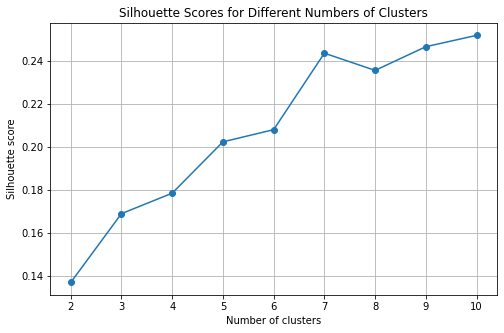

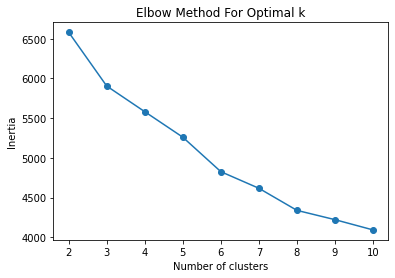

Optimal number of clusters determined to be: 6


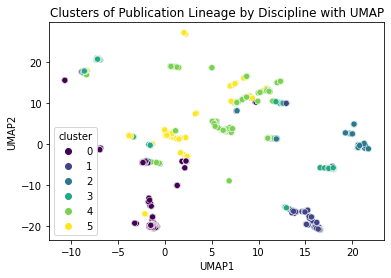

In [31]:
# UMAP clustering
discipline_lineage_pivot_df = create_clusters(discipline_lineage_pivot_df, "Publication Lineage by Discipline", "UMAP", max_k=10)

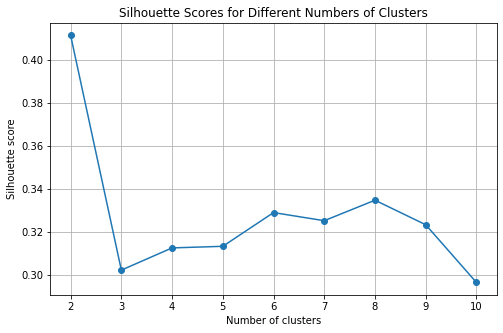

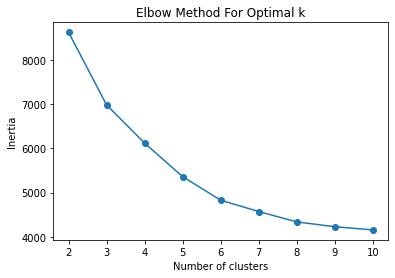

Optimal number of clusters determined to be: 5


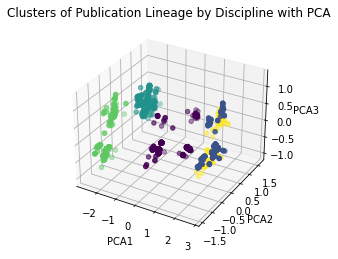

In [32]:
# PCA clustering
discipline_lineage_pivot_df = create_clusters(discipline_lineage_pivot_df, "Publication Lineage by Discipline", "PCA", max_k=10)

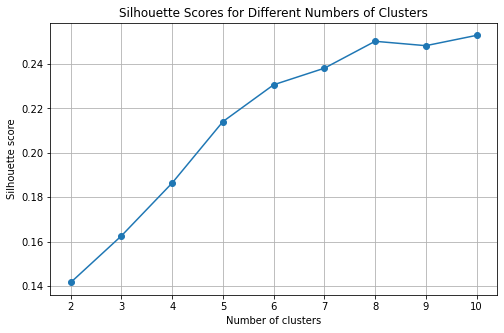

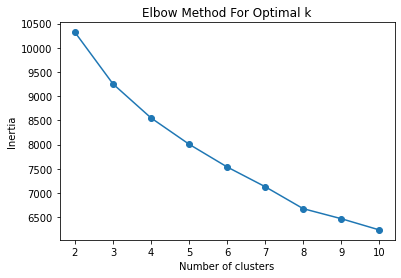

Optimal number of clusters determined to be: 5


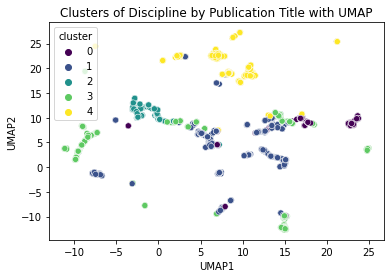

In [33]:
# UMAP clustering
discipline_title_pivot_df = create_clusters(discipline_title_pivot_df, "Discipline by Publication Title", "UMAP", max_k=10)

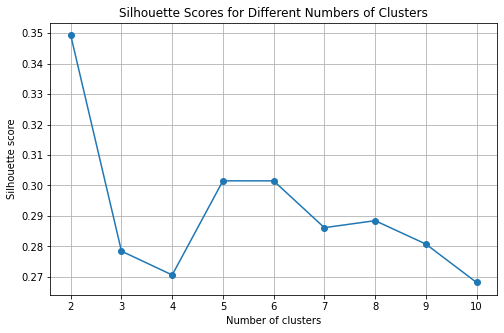

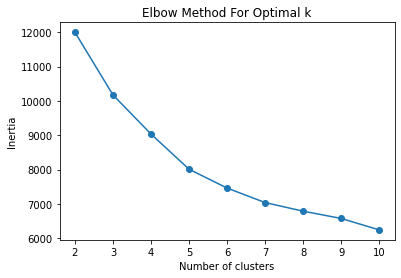

Optimal number of clusters determined to be: 5


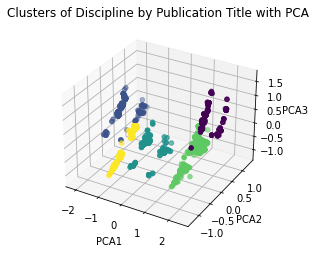

In [34]:
# PCA clustering
discipline_title_pivot_df = create_clusters(discipline_title_pivot_df, "Discipline by Publication Title", "PCA", max_k=10)

In [35]:
discipline_lineage_pivot_df = clean_pivot_df(discipline_lineage_pivot_df, "lineage")
discipline_title_pivot_df = clean_pivot_df(discipline_title_pivot_df, "publication_title")

In [36]:
discipline_lineage_melted_df = pd.melt(discipline_lineage_pivot_df, id_vars=['lineage', 'umap_cluster', 'pca_cluster'], var_name='discipline', value_name='counts')

discipline_lineage_melted_df = discipline_lineage_melted_df[discipline_lineage_melted_df['counts'] > 0]


discipline_title_melted_df = pd.melt(discipline_title_pivot_df, id_vars=['publication_title', 'umap_cluster', 'pca_cluster'], var_name='discipline', value_name='counts')

discipline_title_melted_df = discipline_title_melted_df[discipline_title_melted_df['counts'] > 0]

In [37]:
len(discipline_lineage_melted_df), len(discipline_title_melted_df), len(final_lineage_data), len(final_title_data)

(8583, 13269, 8583, 13269)

In [38]:
final_lineage_data = pd.merge(final_lineage_data, discipline_lineage_melted_df[['lineage', 'umap_cluster', 'pca_cluster', 'discipline']], on=['lineage', 'discipline'], how='left')
final_title_data = pd.merge(final_title_data, discipline_title_melted_df[['publication_title', 'umap_cluster', 'pca_cluster', 'discipline']], on=['publication_title', 'discipline'], how='left')


In [39]:
final_lineage_data.pca_cluster.value_counts()

2    2478
0    1860
1    1823
3    1423
4     999
Name: pca_cluster, dtype: int64

In [40]:
final_title_data.pca_cluster.value_counts()

3    4775
1    2932
4    2850
2    1514
0    1198
Name: pca_cluster, dtype: int64

In [41]:
final_lineage_data.groupby(['pca_cluster', 'discipline_category']).size().reset_index(name='counts').sort_values(by=['pca_cluster', 'counts'], ascending=[True, False])

pca_cluster discipline_category  counts
1            0                STEM     974
0            0          Humanities     647
2            0     Social Sciences     239
3            1          Humanities    1507
5            1     Social Sciences     294
4            1                STEM      22
8            2     Social Sciences    1999
7            2                STEM     305
6            2          Humanities     174
11           3     Social Sciences    1046
9            3          Humanities     372
10           3                STEM       5
14           4     Social Sciences     910
13           4                STEM      50
12           4          Humanities      39

In [51]:
final_title_data.groupby(['pca_cluster', 'discipline_category']).size().reset_index(name='counts').sort_values(by=['pca_cluster', 'counts'], ascending=[True, False])

pca_cluster discipline_category  counts
0            0          Humanities    1010
2            0     Social Sciences     180
1            0                STEM       8
3            1          Humanities    2332
5            1     Social Sciences     534
4            1                STEM      66
8            2     Social Sciences    1389
7            2                STEM      75
6            2          Humanities      50
11           3     Social Sciences    3767
10           3                STEM     711
9            3          Humanities     297
13           4                STEM    1514
14           4     Social Sciences     962
12           4          Humanities     374

In [44]:
final_title_data[final_title_data.discipline == "Humanities"].pca_cluster.value_counts()

1    1009
3      60
0      45
2       3
4       2
Name: pca_cluster, dtype: int64

In [46]:
final_title_data[final_title_data.pca_cluster == "1"].discipline.value_counts()

Humanities                              1009
Language & Literature                    616
Area Studies                             195
Religion                                 185
Philosophy                               150
History                                  107
Social Sciences                           96
Classical Studies                         65
Jewish Studies                            42
Asian Studies                             31
American Studies                          29
Irish Studies                             28
Folklore                                  24
Film Studies                              24
Linguistics                               23
Education                                 22
Bibliography                              22
Arts                                      18
Latin American Studies                    18
Science & Mathematics                     16
Performing Arts                           16
Middle East Studies                       15
African St

##### Collaborative Filtering

In [52]:
existing_jstor_publications = ['The American Historical Review',
       'The Journal of American History', 'The English Historical Review',
       'History', 'Language Resources and Evaluation',
       'Computers and the Humanities', 'Past & Present',
       'The Mississippi Valley Historical Review']

existing_jstor_publications = ["English Literary History", "American Literature", "Shakespeare Quarterly", "Journal of Popular Culture", "Caribbean Quarterly", "Yale French Studies", "Comparative Literary Studies", "Research in African Literatures", "Critical Inquiry", "Social Text", "Signs"]

# discipline_data[discipline_data.publication_title.isin(subset_titles)].discipline.value_counts()

In [53]:
existing_items = exploded_lineage_disciplines[exploded_lineage_disciplines.publication_title.isin(existing_jstor_publications)][['title_id', 'lineage', 'lineage_active_years', 'lineage_has_wiki']].drop_duplicates()
existing_items

title_id          lineage  lineage_active_years  lineage_has_wiki
2480         amerlite         amerlite                    71              True
3770     yalefrenstud     yalefrenstud                    72              True
3865         cariquar         cariquar                    67              True
3979         shakquar     shakassobull                    94              True
6534     reseafrilite     reseafrilite                    50              True
7458  criticalinquiry  criticalinquiry                    44              True
7733            signs            signs                    43              True
8384       socialtext       socialtext                    21              True

In [54]:
final_lineage_data

lineage  lineage_active_years discipline_category  \
0     14centengmystnew                    46          Humanities   
1     14centengmystnew                    46          Humanities   
2     19thcenturymusic                    43          Humanities   
3     19thcenturymusic                    43          Humanities   
4                  291                     2          Humanities   
...                ...                   ...                 ...   
8578            zmanim                    41          Humanities   
8579            zmanim                    41          Humanities   
8580            zmanim                    41     Social Sciences   
8581          zoolbull                   122                STEM   
8582          zoolbull                   122                STEM   

                 discipline  lineage_has_wiki  lineage_title_counts  \
0                Humanities              True                     3   
1                  Religion              True                     3   
2                      Arts              True                     1   
3                     Music              True                     1   
4         Art & Art History              True                     1   
...                     ...               ...                   ...   
8578                History              True                     1   
8579         Jewish Studies              True                     1   
8580           Area Studies              True                     1   
8581    Biological Sciences              True                     2   
8582  Science & Mathematics              True                     2   

     umap_cluster pca_cluster  
0               0           1  
1               0           1  
2               3           0  
3               3           0  
4               3           0  
...           ...         ...  
8578            5           3  
8579            5           3  
8580            5           3  
8581            2           0  
8582            2           0  

[8583 rows x 8 columns]

In [55]:
lineage_discipline_correlation_matrix, lineage_discipline_pivot_df =  create_correlation_matrix_and_pivot_table(final_lineage_data, 'discipline', 'lineage')

In [56]:
lineage_discipline_correlation_matrix[0:1]

lineage           lineage  14centengmystnew  19thcenturymusic       291  \
0        14centengmystnew               1.0         -0.022727 -0.022727   

lineage  aaaarbeanglamer   aafiles  aavnewsletter     abaco  abajafhocodela  \
0               0.333256 -0.022727      -0.027995 -0.022727        -0.01598   

lineage  aborhist  ...  zeitreligeis  zeitreliintejude  zeitsociwirt  \
0       -0.027995  ...           1.0         -0.022727     -0.032513   

lineage  zeitsozi  zeitstaaeuro  zeittheokirc  zeitvergspradeut  \
0       -0.022727     -0.036564           1.0         -0.022727   

lineage  zewibiabeplanta    zmanim  zoolbull  
0              -0.022727 -0.027995 -0.022727  

[1 rows x 2868 columns]

In [57]:
discipline_lineage_correlation_matrix[0:1]

discipline                discipline  African American Studies  \
0           African American Studies                       1.0   

discipline  African Studies  Agriculture  American Indian Studies  \
0                  0.103806    -0.005657                -0.004434   

discipline  American Studies  Anthropology  Aquatic Sciences  Archaeology  \
0                    0.03669      -0.01465         -0.005871    -0.017288   

discipline  Architecture & Architectural History  ...  Slavic Studies  \
0                                      -0.010584  ...       -0.006846   

discipline  Social Sciences  Social Work  Sociology  Statistics  \
0                  0.005812    -0.006846   0.037518   -0.008905   

discipline  Sustainability  Technology  Transportation Studies  Urban Studies  \
0                -0.017442   -0.006078               -0.004703      -0.005871   

discipline   Zoology  
0          -0.010342  

[1 rows x 91 columns]

In [58]:
test = get_similar_items('History', discipline_lineage_correlation_matrix, 'discipline', top_n=10)
test

['American Studies',
 'History of Science & Technology',
 'Area Studies',
 'Science & Technology Studies',
 'Irish Studies',
 'British Studies',
 'European Studies',
 'Religion',
 'Geology',
 'Military Studies']

#### Feature Engineering

In [58]:
def turn_lists_to_strings(df):
    columns_with_lists = df.applymap(lambda x: isinstance(x, list)).any().reset_index().rename(columns={'index':'column_name', 0:'has_list'})

    cols = columns_with_lists[columns_with_lists.has_list == True].column_name.tolist()
    for col in cols:
        df[col] = df[col].astype(str)
    return df

def is_numeric_column(col):
    """Check if a column can be converted to numeric."""
    try:
        pd.to_numeric(col)
        return True
    except ValueError:
        return False

def is_date_column(col):
    """Check if a column can be converted to a date."""
    try:
        pd.to_datetime(col)
        return True
    except (ValueError, TypeError):
        return False

def string_length_classification(col, threshold_label=50):
    """Classify string columns based on their length."""
    max_length = col.str.len().max()
    if max_length <= threshold_label:
        return 'qualitative_label'
    else:
        return 'qualitative_text_vectorized'

def identify_and_drop_empty_columns(df):
    empty_cols_df = df.isna().all().reset_index().rename(columns={0: 'is_null', 'index': 'column_name'})
    empty_cols = empty_cols_df[empty_cols_df.is_null == True].column_name.tolist()
    return df.drop(columns=empty_cols) if len(empty_cols) > 0 else df

def classify_columns(df):
    quantitative_cols = df.select_dtypes(include=np.number).columns.tolist()
    qualitative_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    return quantitative_cols, qualitative_cols

def get_column_types(df):
    numb_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    date_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
    return numb_cols, date_cols

def calculate_unique_values(df):
    unique_vals = df.apply(pd.Series.nunique).reset_index().rename(columns={'index':'column_name', 0:'unique_values'})
    unique_vals['unique_values'] = unique_vals['unique_values'].astype(int)
    unique_vals['total_unique_values'] = unique_vals['unique_values'] / len(df) * 100
    return unique_vals

def identify_missing_values(df):
    missing_vals = df.isnull().sum().reset_index().rename(columns={'index':'column_name', 0:'missing_values'})
    missing_vals['total_missing'] = missing_vals['missing_values'] / len(df) * 100
    mean_value = missing_vals.total_missing.mean()
    missing_vals['minimal_missing'] = missing_vals.total_missing < mean_value
    return missing_vals

def classify_columns_for_categorical(df, unique_vals, missing_vals,):
    """
    Enhanced function to classify columns based on data type and content.
    """
    # column_distribution_df = pd.DataFrame(df.columns, columns=['column_name'])
    column_distribution_df = pd.merge(unique_vals, missing_vals, on='column_name', how='inner')
    column_distribution_df['data_type'] = 'qualitative'
    column_distribution_df['category'] = None

    # Identify data types
    for col in df.columns:
        if is_numeric_column(df[col]):
            column_distribution_df.loc[column_distribution_df.column_name == col, 'data_type'] = 'quantitative'
        elif is_date_column(df[col]):
            column_distribution_df.loc[column_distribution_df.column_name == col, 'data_type'] = 'date'
        elif df[col].dtype == object:
            str_class = string_length_classification(df[col])
            column_distribution_df.loc[column_distribution_df.column_name == col, 'data_type'] = str_class

    # Classify constant, binary, and missing data
    # column_distribution_df.loc[column_distribution_df.minimal_missing == False, 'category'] = "missing_data"
    column_distribution_df.loc[(column_distribution_df.unique_values == 1), 'category'] = "constant"
    column_distribution_df.loc[(column_distribution_df.unique_values == 2), 'category'] = "binary"

    # Classify remaining columns
    remaining_cols = column_distribution_df[column_distribution_df.category.isnull()]
    quantiles = remaining_cols['unique_values'].quantile([0, .33, .66, 1])
    categories = ["well suited for categorical", "could be categorical", "too many for categorical"]
    column_distribution_df.loc[column_distribution_df.category.isnull(), 'category'] = pd.cut(remaining_cols['unique_values'], bins=quantiles, labels=categories, include_lowest=True)

    return column_distribution_df

cleaned_finalized_publication_data = turn_lists_to_strings(finalized_publication_data)

cleaned_finalized_publication_data = identify_and_drop_empty_columns(cleaned_finalized_publication_data)

quantitative_cols, qualitative_cols = classify_columns(cleaned_finalized_publication_data)


print("Quantitative columns:", len(quantitative_cols), quantitative_cols)
print("Qualitative columns:", len(qualitative_cols), qualitative_cols)

numb_cols, date_cols = get_column_types(cleaned_finalized_publication_data)
unique_vals = calculate_unique_values(cleaned_finalized_publication_data)
missing_vals = identify_missing_values(cleaned_finalized_publication_data)

column_distribution_df = classify_columns_for_categorical(cleaned_finalized_publication_data, unique_vals, missing_vals)

Quantitative columns: 22 ['discipline_count_per_lineage', 'discipline_count_per_title', 'lineage_active_years', 'lineage_compared_cv_disciplinary_category_lifespan', 'lineage_compared_cv_disciplinary_lifespan', 'lineage_compared_disciplinary_category_lifespan', 'lineage_compared_disciplinary_lifespan', 'lineage_std_disciplinary_category_lifespan', 'lineage_std_disciplinary_lifespan', 'title_active_years', 'title_compared_cv_disciplinary_category_lifespan', 'title_compared_cv_disciplinary_lifespan', 'title_compared_disciplinary_category_lifespan', 'title_compared_disciplinary_lifespan', 'title_std_disciplinary_category_lifespan', 'title_std_disciplinary_lifespan', 'total_lineage_cv', 'total_lineage_relative_difference', 'total_lineage_zscore', 'total_title_cv', 'total_title_relative_difference', 'total_title_zscore']
Qualitative columns: 44 ['access_type', 'aggregated_disciplines', 'archive_release_date', 'catalog_identifier_lccn', 'catalog_identifier_oclc', 'coerced_date_first_issue_on

##### Random Forest

In [129]:
exploded_titles_disciplines = discipline_data.explode("discipline")
exploded_titles_disciplines.discipline = exploded_titles_disciplines.discipline.str.strip()
disciplinary_designations = disciplinary_designations.rename(columns={'aggregated_disciplines': 'discipline'})
exploded_titles_disciplines = pd.merge(exploded_titles_disciplines, disciplinary_designations, on="discipline", how="left")

final_title_data = exploded_titles_disciplines[exploded_titles_disciplines.discipline.notna()].copy()
final_title_data = final_title_data.groupby(['publication_title', 'title_active_years_bin', 'title_active_years', 'discipline_category', 'discipline', 'title_has_wiki']).size().reset_index(name='title_counts').drop_duplicates()

In [105]:
grouped_final_title_data = final_title_data.groupby(['publication_title', 'title_active_years', 'discipline_category', 'discipline', 'title_has_wiki']).size().reset_index(name='title_counts').drop_duplicates()

In [107]:
grouped_final_title_data.sort_values(by='title_counts', ascending=False)

publication_title  title_active_years  \
0                                       'Atiqot / עתיקות                  33   
8851                                 QUANTUM Information                   4   
8841                                             Publius                  47   
8842                                             Publius                  47   
8843                 Pushkin Review / Пушкинский вестник                  22   
...                                                  ...                 ...   
4425                          Illinois Classical Studies                  44   
4426                         Illinois Historical Journal                  15   
4427                         Illinois Historical Journal                  15   
4428                         Illinois Historical Journal                  15   
13268  В помощь преподавателю русского языка в Америк...                  19   

      discipline_category                      discipline  title_has_wiki  \
0         Social Sciences                     Archaeology            True   
8851      Social Sciences                       Sociology            True   
8841      Social Sciences  Public Policy & Administration            True   
8842      Social Sciences                 Social Sciences            True   
8843           Humanities                      Humanities           False   
...                   ...                             ...             ...   
4425           Humanities                      Humanities            True   
4426           Humanities                         History            True   
4427      Social Sciences                American Studies            True   
4428      Social Sciences                    Area Studies            True   
13268     Social Sciences                    Area Studies            True   

       title_counts  
0                 1  
8851              1  
8841              1  
8842              1  
8843              1  
...             ...  
4425              1  
4426              1  
4427              1  
4428              1  
13268             1  

[13269 rows x 6 columns]

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [97]:
# Vectorize the titles
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(final_title_data['publication_title'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Prepare the target variable
y = final_title_data['discipline']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [99]:


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


                                      precision    recall  f1-score   support

            African American Studies       0.00      0.00      0.00         8
                     African Studies       0.00      0.00      0.00        24
                         Agriculture       0.00      0.00      0.00         7
             American Indian Studies       0.00      0.00      0.00         1
                    American Studies       0.03      0.03      0.03        35
                        Anthropology       0.05      0.02      0.03        44
                    Aquatic Sciences       0.00      0.00      0.00        10
                         Archaeology       0.10      0.04      0.05        53
Architecture & Architectural History       0.00      0.00      0.00        23
                        Area Studies       0.04      0.02      0.03       242
                   Art & Art History       0.13      0.10      0.11        80
                                Arts       0.13      0.08      

In [100]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {tfidf_vectorizer.get_feature_names_out()[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature of (0.06323077543325284)
2. feature the (0.05442077597687735)
3. feature journal (0.05039769208148841)
4. feature and (0.03986982148769464)
5. feature american (0.024813897879219414)
6. feature society (0.02346485690594055)
7. feature review (0.02276416971188492)
8. feature bulletin (0.021039507355497332)
9. feature law (0.020536192054620005)
10. feature studies (0.019745436534211572)
11. feature art (0.01888727078005247)
12. feature education (0.018218936599022247)
13. feature in (0.018048131578433473)
14. feature history (0.01743374405030227)
15. feature historical (0.016949586469351026)
16. feature international (0.01631289812188196)
17. feature quarterly (0.016297942165316808)
18. feature research (0.01510735713582076)
19. feature economic (0.013059529255336332)
20. feature association (0.013056829945946959)
21. feature science (0.012837510151455844)
22. feature health (0.012815110030975796)
23. feature economics (0.012722679369071307)
24. feature de (0.

In [101]:
# Get feature importances
importances = model.feature_importances_

# Select the top N features
N = 10  # Number of top features to select
top_indices = np.argsort(importances)[::-1][:N]
top_feature_names = tfidf_vectorizer.get_feature_names_out()[top_indices]

# Create a new DataFrame with only the top features
top_features_df = tfidf_df[top_feature_names]

In [103]:
final_title_data.columns

Index(['publication_title', 'title_active_years', 'discipline_category',
       'discipline', 'title_has_wiki', 'publication_title_counts',
       'umap_cluster', 'pca_cluster'],
      dtype='object')

In [109]:
# Combine with top TF-IDF features
combined_features = pd.concat([final_title_data[['title_active_years', 'title_has_wiki', 'discipline_category']], top_features_df], axis=1)

# Encoding categorical features
label_encoder = LabelEncoder()
combined_features['title_active_years'] = label_encoder.fit_transform(combined_features['title_active_years'])
combined_features['discipline_category'] = label_encoder.fit_transform(combined_features['discipline_category'])

# Encoding the target variable
y = final_title_data['discipline']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.5, random_state=42)

# Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [110]:

# Evaluate the model
print(classification_report(y_test, y_pred, ))

                                      precision    recall  f1-score   support

            African American Studies       0.00      0.00      0.00        15
                     African Studies       0.00      0.00      0.00        50
                         Agriculture       0.00      0.00      0.00        10
             American Indian Studies       0.00      0.00      0.00         4
                    American Studies       0.06      0.03      0.04        68
                        Anthropology       0.04      0.03      0.03        72
                    Aquatic Sciences       0.00      0.00      0.00        17
                         Archaeology       0.04      0.02      0.03        87
Architecture & Architectural History       0.08      0.05      0.06        37
                        Area Studies       0.14      0.15      0.14       395
                   Art & Art History       0.10      0.12      0.11       128
                                Arts       0.09      0.08      

In [111]:
report = classification_report(y_test, y_pred, output_dict=True, labels=model.classes_)

In [112]:
# Extract F1 scores
f1_scores = {class_name: report[class_name]['f1-score'] for class_name in model.classes_}

In [113]:

report = classification_report(y_test, y_pred, output_dict=True)

# Extract F1 scores
f1_scores = {class_name: report[class_name]['f1-score'] for class_name in report if class_name != 'accuracy' and not class_name.startswith('macro avg') and not class_name.startswith('weighted avg')}


In [114]:
def class_wise_top_features(class_importances, classes, combined_features, f1_scores, top_n=3):
    top_features_per_class = {}
    for i, class_label in enumerate(classes):
        # Check if F1 score for this class is greater than 0
        if f1_scores.get(class_label, 0) > 0:
            # Get indices of top N features
            top_indices = np.argsort(class_importances[i])[-top_n:][::-1]
            top_features = [combined_features.columns[index] for index in top_indices]
            top_features_per_class[class_label] = top_features
    return top_features_per_class

def class_wise_feature_importance(model, X_train):
    # Initialize an empty array to store feature importances
    class_importances = np.zeros((len(model.classes_), X_train.shape[1]))

    # Iterate over each class
    for i, class_label in enumerate(model.classes_):
        # Get the feature importances for the current class
        class_importances[i] = model.estimators_[i].feature_importances_

    return class_importances
# Compute class-wise feature importances
class_importances = class_wise_feature_importance(model, X_train)

# Get unique classes from the dataset
unique_classes = final_title_data['discipline'].unique()

# Get top features for each class
top_features_per_class = class_wise_top_features(class_importances, unique_classes, combined_features, f1_scores)

# Print the top features
for class_label, features in top_features_per_class.items():
    print(f"Class: {class_label}, Top Features: {features}")


Class: Archaeology, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Social Sciences, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Humanities, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Religion, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Arts, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: History, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Art & Art History, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: History of Science & Technology, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Science & Mathematics, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Biological Sciences, Top Features: ['title_active_years', 'discipline_category', 'of']
Class: Architecture & Architectural History, Top Features: ['title_active_years', 'discipline_category', 'o

In [115]:
def class_wise_feature_importance(model, X_train):
    # Initialize an array to store feature importances
    n_classes = len(model.classes_)
    n_features = X_train.shape[1]
    class_wise_importances = np.zeros((n_classes, n_features))

    # Iterate over all trees in the random forest
    for tree in model.estimators_:
        # Extract the decision tree classifier from the tree in the random forest
        dtree = tree.tree_

        # Iterate over all nodes of the tree
        for node in range(dtree.node_count):
            # Check if the node is a leaf node
            if dtree.children_left[node] == dtree.children_right[node]:
                # Get the output class of the node and its weight
                output_class = np.argmax(dtree.value[node])
                weight = dtree.weighted_n_node_samples[node]

                # Calculate feature importances and add them to the class-wise importances
                # The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature
                for feature in range(n_features):
                    if dtree.feature[feature] >= 0:
                        class_wise_importances[output_class, feature] += (dtree.impurity[node] - dtree.impurity[dtree.children_left[node]] - dtree.impurity[dtree.children_right[node]]) * weight

    # Normalize the feature importances
    class_wise_importances /= np.sum(class_wise_importances, axis=1, keepdims=True)

    return class_wise_importances

# Compute class-wise feature importances
class_importances = class_wise_feature_importance(model, X_train)

def class_wise_top_features(class_importances, model, combined_features, f1_scores, top_n=3):
    top_features_per_class = {}
    for i, class_label in enumerate(model.classes_):
        # Check if F1 score for this class is greater than 0
        if f1_scores[class_label] > 0:
            # Get indices of top N features
            top_indices = np.argsort(class_importances[i])[-top_n:][::-1]
            print(top_indices)
            top_features = [combined_features.columns[index] for index in top_indices]
            top_features_per_class[class_label] = top_features
    return top_features_per_class

# Get top features for each class
top_features_per_class = class_wise_top_features(class_importances, model, combined_features, f1_scores)

# Print the top features
for class_label, features in top_features_per_class.items():
    print(f"Class: {class_label}, Top Features: {features}")


[12 11 10]
[12 11 10]
[12 11 10]
[12 11 10]
[12 11 10]
[12 11 10]
[12 11 10]


KeyError: 'Astronomy'

### Visualize Length of Predicted Journals

In [147]:
global_txt_file

publication_title print_identifier  \
0               14th Century English Mystics Newsletter        0737-5840   
1                                    19th-Century Music        0148-2076   
2                             20 & 21. Revue d'histoire        2649-664X   
3                                                   291        1054-7193   
4                                             4S Review        0738-0526   
...                                                 ...              ...   
4516  Zeitschrift für wissenschaftliche Biologie. Ab...        1866-2749   
4517                                        Zion / ציון        0044-4758   
4518  Zion: Me'asef ha-Hevra ha-erets-yisre'elit le-...        0792-528X   
4519  Zmanim: A Historical Quarterly / זמנים: רבעון ...        1565-5261   
4520                                Zoological Bulletin        0898-1051   

     online_identifier date_first_issue_online num_first_vol_online  \
0                  NaN              1974-12-01                    1   
1            1533-8606              1977-07-01                    1   
2            2649-6100              2019-01-01                  NaN   
3                  NaN              1915-03-01                  NaN   
4                  NaN              1983-04-01                    1   
...                ...                     ...                  ...   
4516               NaN              1925-01-01                    1   
4517               NaN              1935-10-01                    א   
4518               NaN              1925-01-01                    1   
4519               NaN              1979-10-01                  NaN   
4520               NaN              1897-08-01                    1   

     num_first_issue_online date_last_issue_online num_last_vol_online  \
0                         1             1983-12-01                   9   
1                         1             2019-10-01                  43   
2                       141             2019-10-01                 NaN   
3                         1             1916-02-01                 NaN   
4                         1             1985-12-01                   3   
...                     ...                    ...                 ...   
4516                      1             1934-01-01                  21   
4517                      א             2017-01-01                  פב   
4518                    NaN             1933-01-01                   6   
4519                      1             2019-01-01                 NaN   
4520                      1             1899-09-01                   2   

     num_last_issue_online                                          title_url  \
0                        4  https://www-jstor-org.proxy2.library.illinois....   
1                        2  https://www-jstor-org.proxy2.library.illinois....   
2                      144  https://www-jstor-org.proxy2.library.illinois....   
3                       12  https://www-jstor-org.proxy2.library.illinois....   
4                        4  https://www-jstor-org.proxy2.library.illinois....   
...                    ...                                                ...   
4516                     4  https://www-jstor-org.proxy2.library.illinois....   
4517                     ד  https://www-jstor-org.proxy2.library.illinois....   
4518                   NaN  https://www-jstor-org.proxy2.library.illinois....   
4519                   140  https://www-jstor-org.proxy2.library.illinois....   
4520                     6  https://www-jstor-org.proxy2.library.illinois....   

      ...  processed_date_last_issue_online lineage_active_years  \
0     ...                        1983-12-01                   46   
1     ...                        2019-10-01                   43   
2     ...                        2019-10-01                   36   
3     ...                        1916-02-01                    2   
4     ...                        1985-12-01                   55   
..